In [3]:
import pandas as pd
import pickle
import os
import glob
from tqdm import tqdm

In [4]:
# Overall set up
ROOTFOLDER = "/lustre1/g/geog_pyloo/05_timemachine"
PATH_PATH = "{ROOTFOLDER}/GSV/gsv_rgb/{cityabbr}/gsvmeta/gsv_path.csv"
CURATED_FOLDER = f"{ROOTFOLDER}/_curated"
TRANSFOM_FOLDER = f"{ROOTFOLDER}/_transformed"
EXFOLDER_SEG_LONG = os.path.join(CURATED_FOLDER, "c_seg_longitudinal_all")
OBJECT_SOURCE_FOLDER = "{CURATED_FOLDER}/{city_abbr}/*_objects.parquet"
PATH_TRANSFOM_FOLDER = f"{TRANSFOM_FOLDER}/t_human_attr/sel_path"
if not os.path.exists(PATH_TRANSFOM_FOLDER):
    os.makedirs(PATH_TRANSFOM_FOLDER)
PATH_SEL = "{PATH_TRANSFOM_FOLDER}/{city_abbr}.csv"

In [28]:
# load the human prediction result and only focus on images with at least one person
# city = "Hong Kong"
def get_city_path(city):
    """Get the path of the images with at least one person in the city"""
    cityabbr = city.replace(" ", "").lower()
    df_path = pd.read_csv(PATH_PATH.format(ROOTFOLDER=ROOTFOLDER, cityabbr=cityabbr))
    objfiles = glob.glob(OBJECT_SOURCE_FOLDER.format(CURATED_FOLDER=CURATED_FOLDER, city_abbr=cityabbr))
    df = pd.concat([pd.read_parquet(f) for f in objfiles])

    df_path['img'] = df_path['path'].apply(lambda x: x.split("/")[-1])
    df_path_sel = df[df['object_name']=='person'].drop_duplicates("img").merge(df_path, on='img')[['path']]

    df_path_sel = df[df['object_name']=='person'].drop_duplicates("img").merge(df_path, on='img')[['path']]

    df_path_sel.to_csv(PATH_SEL.format(PATH_TRANSFOM_FOLDER = PATH_TRANSFOM_FOLDER, city_abbr=cityabbr), 
                    index=False)
    return print(f"Done {city}")

In [68]:
# FIX ME: remove all of these pickle files:

In [126]:
COLS_NAME = ['gender',
              'age', 
              'side',
              'glasses', 
              'hat', 
              'obs_front',
              'bags',
              'upper',
              'lower',
              'shoes',
              'idx',
            'confidence',
              'x1','y1','x2','y2']

In [157]:
# CLEAN UP RESULTS
# test_file = results_files[-1]
# load the file
def process_one_img(test_file):
  with open(test_file, 'rb') as f:
      data = pickle.load(f)
  try: 
      df = pd.concat([pd.DataFrame(data[0]['human_attr']), pd.DataFrame(data[0]['boxes'])], axis=1)
      df.columns = COLS_NAME
      df['img'] = data[0]['img']
      return df
  except:
      return test_file
  
def process_one_batch(test_file):
    with open(test_file, 'rb') as f:
      data = pickle.load(f)

    alldf = []
    for d in data:
        try:
            temp = pd.concat([pd.DataFrame(d['human_attr']),  pd.DataFrame(d['boxes'])], axis=1)
            temp.columns = COLS_NAME
            temp['img'] = d['img']
            alldf.append(temp)
        except:
            continue
    return pd.concat(alldf).reset_index(drop=True)

In [128]:
folder = "/lustre1/g/geog_pyloo/05_timemachine/_curated/c_human_attr/hongkong_r2"
# os.listdir(folder)

In [289]:
city = "Hong Kong"
cityabbr = city.replace(" ", "").lower()
results_folder = f"/lustre1/g/geog_pyloo/05_timemachine/_curated/c_human_attr/{cityabbr}" # temporary check the result using a bigger weight
results_files = glob.glob(f"{results_folder}/human_attr_*.pickle")
# remove all of these files
for f in tqdm(results_files):
    os.remove(f)

100%|██████████| 106563/106563 [01:08<00:00, 1555.16it/s]


In [290]:
city = "Paris"
cityabbr = city.replace(" ", "").lower()
results_folder = f"/lustre1/g/geog_pyloo/05_timemachine/_curated/c_human_attr/{cityabbr}" # temporary check the result using a bigger weight
results_files = glob.glob(f"{results_folder}/human_attr_*.pickle")
print("Number of files: ", len(results_files))
full_result = []
error_files = []
for test_file in tqdm(results_files):
  # df = process_one_img(test_file)
  df = process_one_batch(test_file)
  if type(df) == str:
      error_files.append(df)
      if len(error_files) % 100 == 0:
          print(f"Error files: {len(error_files)}")
  else:
    full_result.append(df)
full_result = pd.concat(full_result).reset_index(drop=True)
full_result.to_csv(f"{results_folder}/human_attr_all.csv", index=False)

Number of files:  102


100%|██████████| 102/102 [01:03<00:00,  1.59it/s]


In [63]:
# load all cities
city_ls = pd.read_csv("../city_meta.csv")

In [64]:
header = """conda activate paddle117
module load cuda-toolkit/11.7
"""
test_img_path = """/lustre1/g/geog_pyloo/05_timemachine/_transformed/t_human_attr/sel_path/{cityabbr}.csv"""
lines = """python deploy/pipeline/pipeline_no_viz.py --config deploy/pipeline/config/infer_cfg_pphuman.yml \
                                                   --image_path={test_img_path} \
                                                   --device=gpu \
                                                   --output_dir=/lustre1/g/geog_pyloo/05_timemachine/_curated/c_human_attr/{cityabbr} \
                                                   --visual=False \
                                                   --save_result=True
                                                   """
city_to_send = city_ls['City'].unique()
batch_size = 10
for i in range(0, len(city_to_send), batch_size):
    city_batch = city_to_send[i:i+batch_size]
    with open(f"run_human_attr_{i}.sh", "a") as f:
        for city in city_batch:
            if city in ["Hong Kong", "Paris"]:
                continue
            
            cityabbr = city.replace(" ", "").lower()
            line_to_send = lines.format(test_img_path=test_img_path.format(cityabbr=cityabbr), cityabbr=cityabbr)
            f.write(line_to_send + "\n")


# Cross-sectional summary
1. age
2. dress-style
3. gender

In [291]:
import h3

In [292]:
################################################
# basic set ups
################################################
ROOTFOLDER = "/lustre1/g/geog_pyloo/05_timemachine"
PANO_PATH = "{ROOTFOLDER}/GSV/gsv_rgb/{cityabbr}/gsvmeta/gsv_pano.csv"
PATH_PATH = "{ROOTFOLDER}/GSV/gsv_rgb/{cityabbr}/gsvmeta/gsv_path.csv"
CURATED_FOLDER = f"{ROOTFOLDER}/_curated"

EXFOLDER = os.path.join(CURATED_FOLDER, "c_human_attr")
EXFOLDER_LONG = os.path.join(EXFOLDER, "c_longitudinal")
EXFOLDER_CROSS = os.path.join(EXFOLDER, "c_cross_sectional")
if not os.path.exists(EXFOLDER):
    os.makedirs(EXFOLDER)
if not os.path.exists(EXFOLDER_LONG):
    os.makedirs(EXFOLDER_LONG)
if not os.path.exists(EXFOLDER_CROSS):
    os.makedirs(EXFOLDER_CROSS)
YEAR_GROUP = ["2015-2018", "2020-2023"]
res = 9

In [386]:
city = 'New York'
city_abbr = city.replace(" ", "").lower()
results_folder = f"/lustre1/g/geog_pyloo/05_timemachine/_curated/c_human_attr/{city_abbr}"
result_file = f"{results_folder}/human_attr_all.csv"
result_file_2 = f"{results_folder}_r2/human_attr_all_r2.csv"
df = pd.read_csv(result_file)
# df = pd.read_csv(result_file_2)
# df.head()

In [387]:
df.groupby('gender').size()

gender
Female    225385
Male      143236
dtype: int64

In [388]:
city_abbr = city.replace(" ", "").lower()
df_pano = pd.read_csv(PANO_PATH.format(ROOTFOLDER=ROOTFOLDER, cityabbr=city_abbr))
df_path = pd.read_csv(PATH_PATH.format(ROOTFOLDER=ROOTFOLDER, cityabbr=city_abbr))
# process the prediction results
df['panoid'] = df['img'].apply(lambda x: x[:22])


# only keep the panoid that has a path
df_pano_inner = df_pano[df_pano['panoid'].isin(df_path['panoid'].unique())].reset_index(drop = True)
print(df_pano_inner.shape[0], "out of ", df_pano.shape[0], "panoids have path")
df_pano_inner['hex_id'] = df_pano_inner.apply(lambda x: h3.geo_to_h3(x['lat'], x['lon'], res), axis=1)


# gender and age (Potential issue, no seasonal information is kept)
df_pano_merge = df.merge(df_pano_inner, on='panoid', how='inner')
df_pano_gender_summary = df_pano_merge.groupby(['hex_id','panoid','gender']).size().unstack().reset_index().fillna(0)
df_pano_age_summary = df_pano_merge.groupby(['hex_id','panoid','age']).size().unstack().reset_index().fillna(0)

# check all available data
df_pano_merge_img = df_pano_inner.groupby(['hex_id'])['panoid'].nunique().reset_index()

353091 out of  2449048 panoids have path


In [389]:
df_pano_gender_summary_hex = df_pano_gender_summary.groupby(['hex_id']).agg(
    {'Female':'sum',
     'Male':'sum'}
).reset_index()

df_pano_age_summary_hex = df_pano_age_summary.groupby(['hex_id']).agg(
    {'Age18-60':'sum',
     'AgeLess18':'sum',
     'AgeOver60':'sum'}
)
df_pano_sumary = df_pano_merge_img.merge(df_pano_gender_summary_hex,
                                         on = 'hex_id', how = 'left')\
                                             .merge(df_pano_age_summary_hex,
                                                    on = 'hex_id', how = 'left').fillna(0)
df_pano_sumary.columns = [x.lower() for x in df_pano_sumary.columns]

df_pano_sumary['person'] = df_pano_sumary['female'] + df_pano_sumary['male']
df_pano_sumary['person_per_pano'] = df_pano_sumary['person'] / df_pano_sumary['panoid']
df_pano_sumary.head()

,hex_id,panoid,female,male,age18-60,ageless18,ageover60,person,person_per_pano
0,892a100002bffff,5,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,892a100002fffff,31,0.0,1.0,1.0,0.0,0.0,1.0,0.032258
2,892a1000047ffff,35,3.0,2.0,3.0,2.0,0.0,5.0,0.142857
3,892a100004fffff,28,4.0,0.0,3.0,1.0,0.0,4.0,0.142857
4,892a1000063ffff,53,6.0,3.0,7.0,0.0,2.0,9.0,0.169811


In [390]:
allcols = ['female', 'male', 'age18-60', 'ageless18',
       'ageover60']
for col in allcols:
    df_pano_sumary[col] = df_pano_sumary[col].astype(int)
    df_pano_sumary[col+'_per'] = df_pano_sumary[col]/df_pano_sumary['person']
df_pano_sumary = df_pano_sumary.fillna(0)

In [391]:
df_pano_sumary.to_csv(os.path.join(EXFOLDER_CROSS, f"{city_abbr}_age_gender.csv"), index=False)

# Find an image with high number of elderly and check the prediction robustness

In [ ]:
df_path['img'] = df_path['path'].apply(lambda x: x.split("/")[-1])
df['with_skirt'] = df['lower'].apply(lambda x: 1 if 'skirt' in x.lower() else 0)

In [ ]:

gendersummary = df.groupby(['img','age']).size().reset_index().rename(columns={0:'count'})\
    .pivot(index='img', columns='age', values='count').reset_index().fillna(0).sort_values('AgeLess18', ascending=False)
sel_random = gendersummary.head(50)
sel_random # Ageless 18 and AgeOver60 are reversed.
# gendersummary

In [412]:

gendersummary = df.groupby(['img','with_skirt']).size().reset_index().rename(columns={0:'count'})\
    .pivot(index='img', columns='with_skirt', values='count').reset_index().fillna(0).sort_values(1, ascending=False)
sel_random = gendersummary.head(50)
sel_random # Ageless 18 and AgeOver60 are reversed.
# gendersummary

with_skirt,img,0,1
149447,kPW85iIox5sFalVAtWOyng_90.jpg,7.0,8.0
89475,S5VXkK06f5trluxE1SeF-w_0.jpg,7.0,8.0
69276,LPRATil_Ew40p4PZIb_8Tg_0.jpg,8.0,7.0
165566,pcNMaHVXkyBEFjNjqNl7bQ_0.jpg,3.0,6.0
113983,Zx3p3_4kaHzuNQpF9MA3ZA_0.jpg,5.0,6.0
128144,dY06U6Ah1W_Yvtbiv5jvaw_90.jpg,2.0,6.0
34100,A-QEEZilE6BVQmLVZzyVIA_0.jpg,0.0,5.0
122459,bf0_Fpzk_lQeP9E1snhaSg_0.jpg,3.0,5.0
112309,ZPNhfJFzbowaM89cXNRMTw_0.jpg,11.0,5.0
15427,3v5PzING_phf_p8rUKWrPA_90.jpg,3.0,5.0


In [393]:
# extract sample images
import shutil
vari_sel = ['AgeLess18', 'Age18-60', 'AgeOver60']
img_folder = f'/lustre1/g/geog_pyloo/05_timemachine/_curated/c_human_attr/c_cross_sectional/_sample_img/{cityabbr}'
for folder in [img_folder]:
    if not os.path.exists(folder):
        os.makedirs(folder)
for var in vari_sel:
    gendersummary = df.groupby(['img','age']).size().reset_index().rename(columns={0:'count'})\
        .pivot(index='img', columns='age', values='count').reset_index().fillna(0).sort_values(var, ascending=False)
    sel_random = gendersummary.head(30)
    path_sel = df_path[df_path['img'].isin(sel_random['img'])].reset_index(drop = True)
    for i in range(path_sel.shape[0]):
        shutil.copy(path_sel.loc[i, 'path'], os.path.join(img_folder, path_sel.loc[i, 'img']))

In [406]:
import seaborn as sns
# use the husl color palette for age
colorls = sns.color_palette("husl", 3)
# plot the color
# convert to rgb color
color_ls_rgb = [(int(x[0]*255), int(x[1]*255), int(x[2]*255)) for x in colorls]
age_color = dict(zip(df['age'].unique(), color_ls_rgb))
gender_color_rgb = [(int(x[0]*255), int(x[1]*255), int(x[2]*255)) for x in sns.color_palette("husl", 2)]
gender_color = dict(zip(df['gender'].unique(), gender_color_rgb))
skirt_color = {0: (0, 0, 0), 1: (255, 0, 0)}

In [407]:
color_schema = {
    'age': age_color,
    'gender':gender_color,
    'with_skirt': skirt_color
}

In [396]:
age_color

{'Age18-60': (246, 112, 136),
 'AgeOver60': (79, 176, 49),
 'AgeLess18': (59, 163, 236)}

In [397]:
sns.color_palette("husl", 3)

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.3126890019504329, 0.6928754610296064, 0.1923704830330379),
 (0.23299120924703914, 0.639586552066035, 0.9260706093977744)]

In [408]:
import cv2
import matplotlib.pyplot as plt
def plot_elderly(df, img, vari = 'age'):
    img_path = df_path[df_path['img']==img]['path'].values[0]
    img_base = cv2.imread(img_path)
    # convert to RGB
    img_rgb = cv2.cvtColor(img_base, cv2.COLOR_BGR2RGB)
    prediction = df[df['img']==img].reset_index(drop = True)
    # draw boxes on the image
    for i, pred in enumerate(prediction.iterrows()):
        x1, y1, x2, y2 = pred[1][['x1', 'y1', 'x2', 'y2']]
        # age = pred[1][vari]
        # print(age)
        color_dict = color_schema[vari]
        cv2.rectangle(img_rgb, (int(x1), int(y1)), (int(x2), int(y2)), color_dict[pred[1][vari]], 2)
    # show the original image and the image with boxes side by side
    fig, ax = plt.subplots(1, 2, figsize=(30, 15))
    ax[0].imshow(cv2.cvtColor(img_base, cv2.COLOR_BGR2RGB))
    ax[0].set_title("Original Image")
    ax[1].imshow(img_rgb)
    ax[1].set_title("Image with Age Boxes")

rp3xaiaPdYGrU2_iNWD9sw_0.jpg


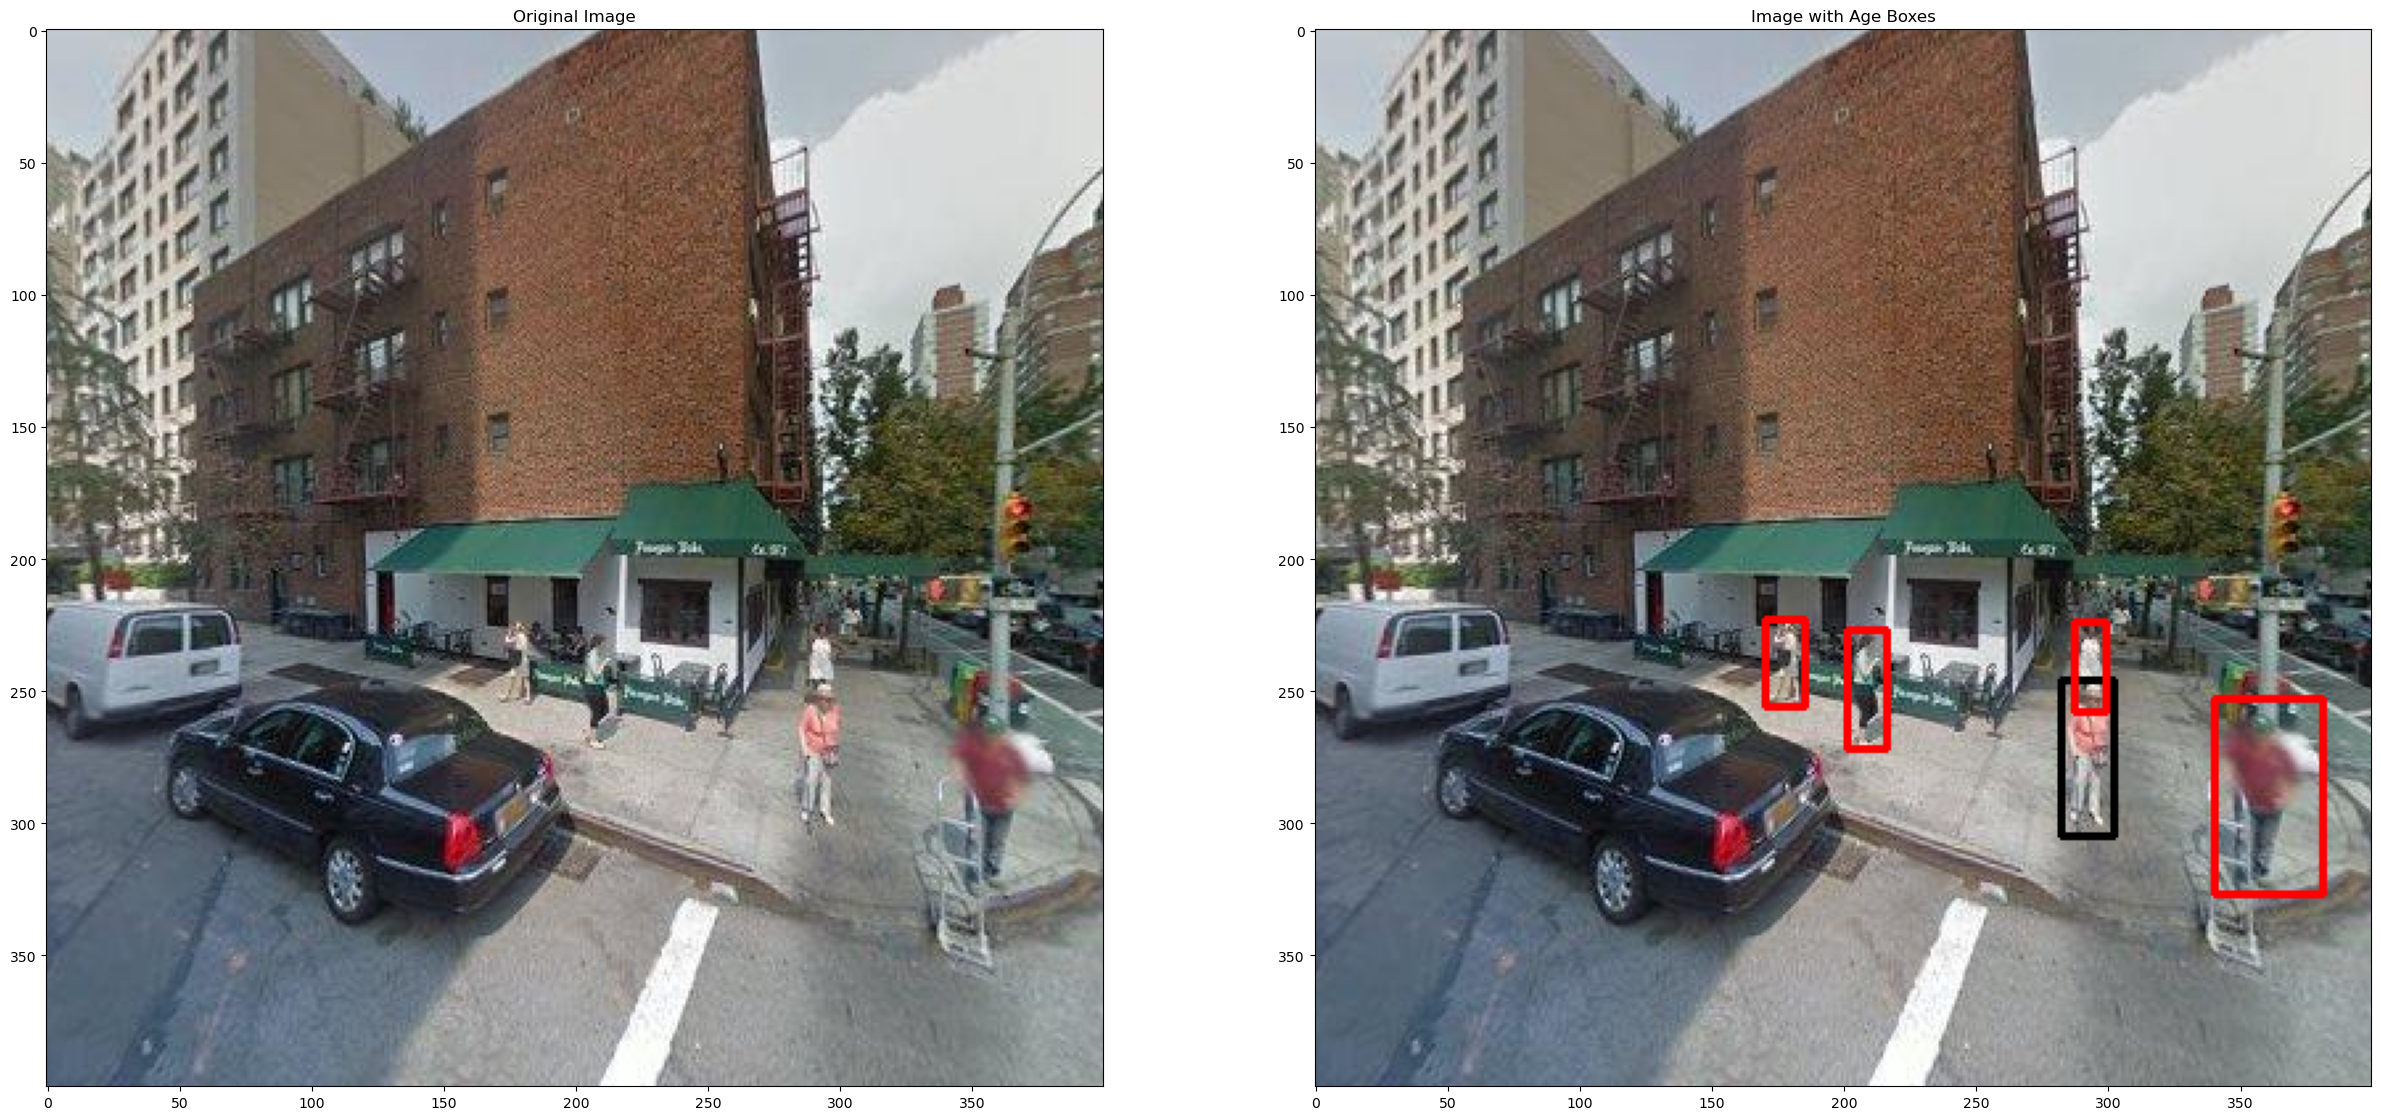

In [433]:
img_sample = sel_random['img'].values[45]
# img_sample = 'KB3nJN_rYT1CY5nF4qZdTQ_270.jpg'
print(img_sample)
plot_elderly(df, img_sample, 'with_skirt')

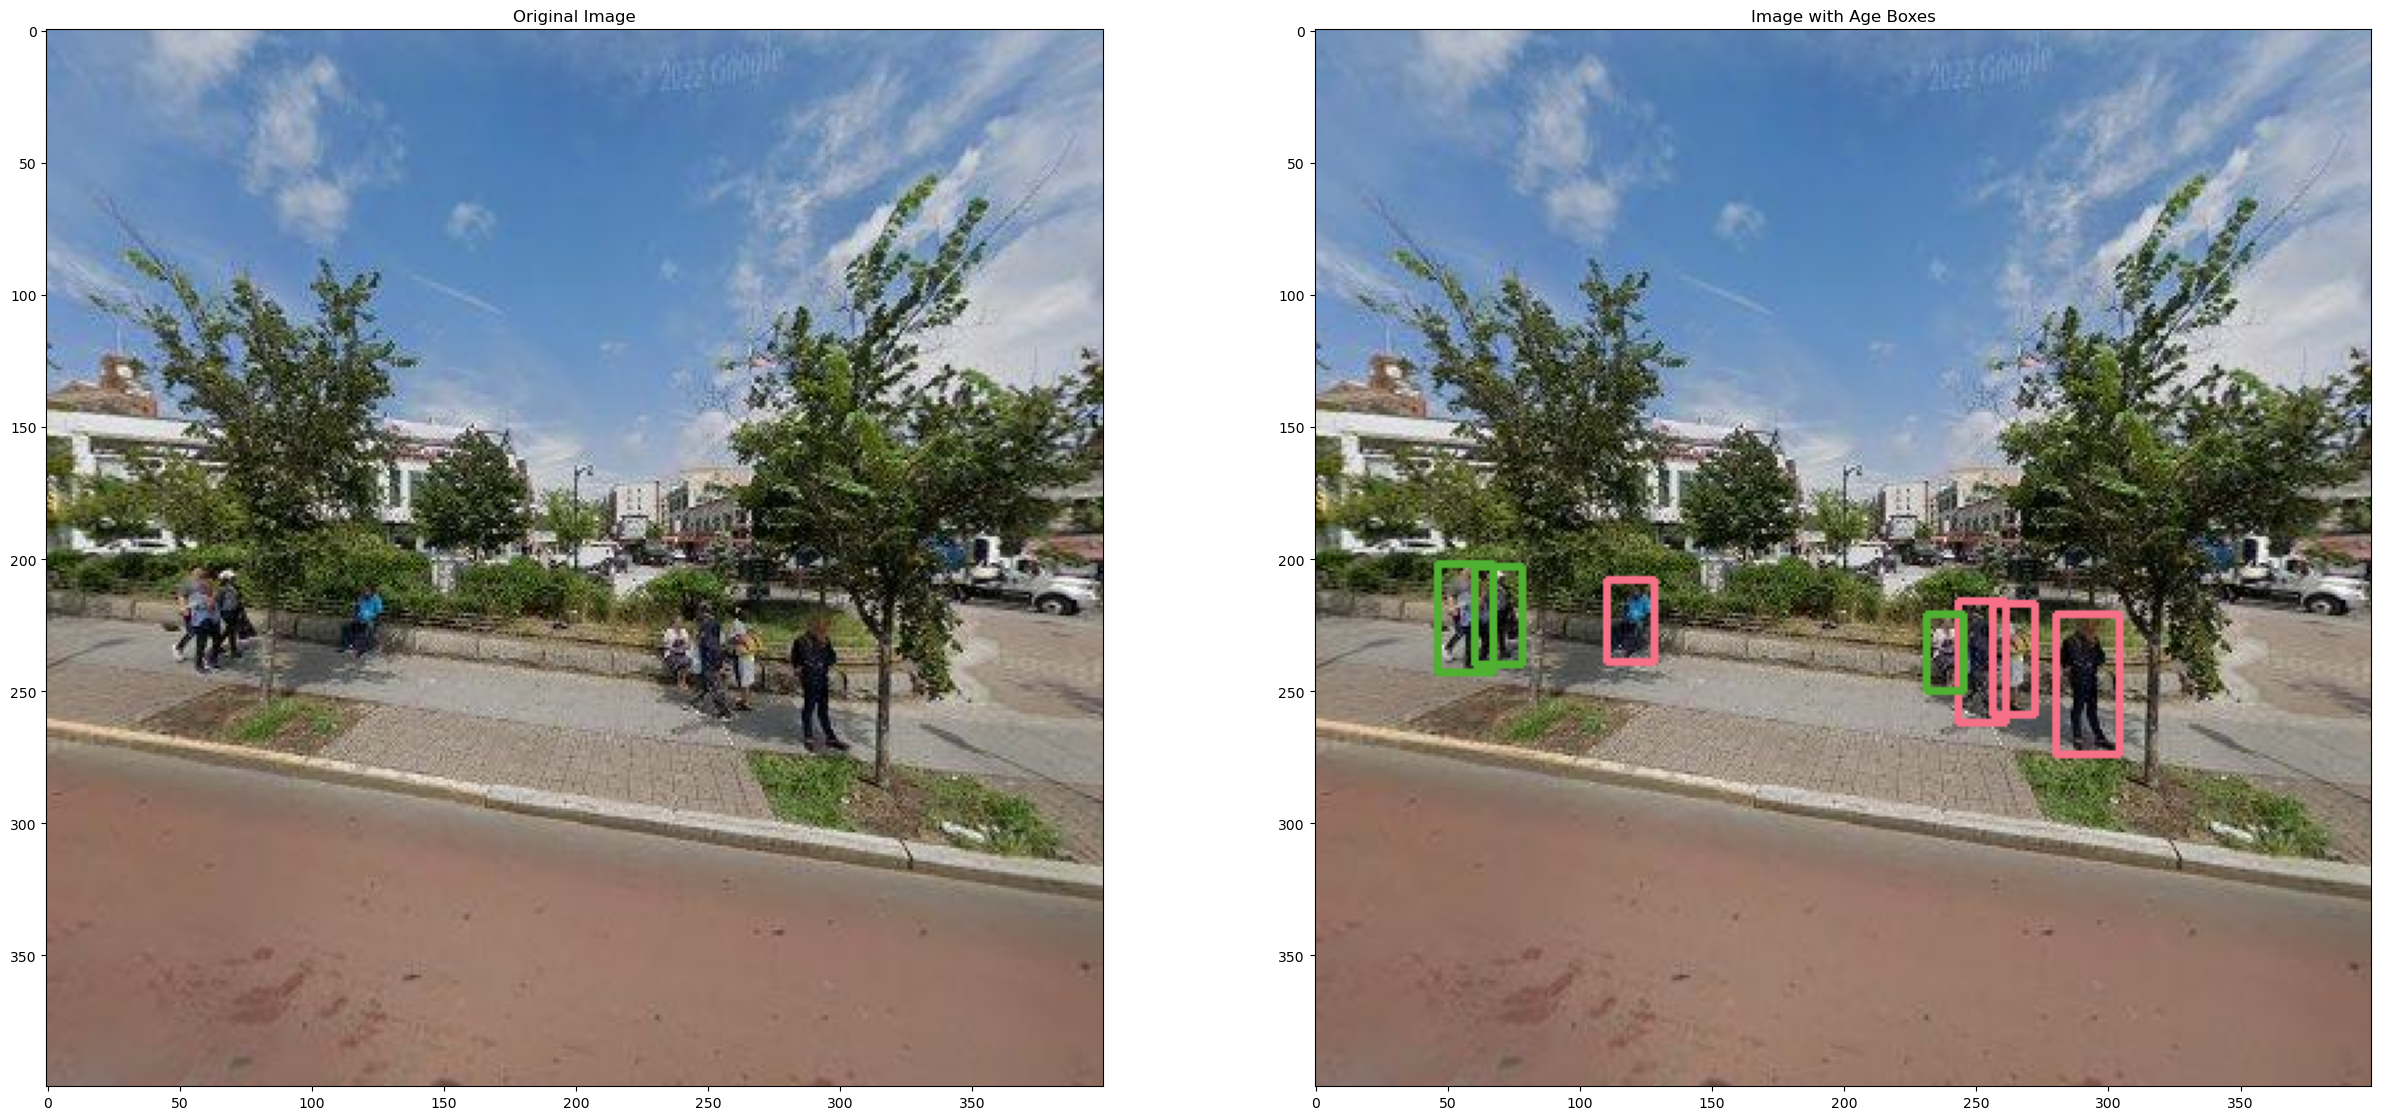

In [432]:

plot_elderly(df, img_sample, 'age')

In [401]:
df['lower'].str.contains('skirt', case = False).sum()

np.int64(31346)

In [403]:
df[(df['gender']=='Female')&(df['lower'].str.contains('skirt', case = False))].shape

(29770, 18)

In [404]:
df['gender'].value_counts()

gender
Female    225385
Male      143236
Name: count, dtype: int64